**#0 Importy**

In [13]:
import numpy as np
import pandas as pd
import string
import itertools
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix, roc_curve, roc_auc_score
)

# Wyłączenie ostrzeżeń NLTK
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

**#1 Wczytanie bazy**

In [14]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])
spam_dataset

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_9716\1996902043.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])


,Spam,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [15]:
print(spam_dataset['Spam'].value_counts(normalize=True))

Spam
0    0.865937
1    0.134063
Name: proportion, dtype: float64


**#2 Usuwanie znaków interpunkcyjnych**

In [16]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))
spam_dataset

,Spam,Text,Cleaned_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...


**#3 Tokenizacja**

In [17]:
def tokenize(text):

    # Usunięcie wielkich liter
    clean_text = text.lower()

    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,..."
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,..."


**#4 Usuwanie stopwords**

In [18]:
stopwords = nltk.corpus.stopwords.words("english")

In [19]:
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b..."


**#6 Lematyzacja**

In [20]:
lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Lemmatized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, go, usf, life, around, though]"
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[pity, mood, soany, suggestion]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitching, acted, like, id, interested, b..."


In [21]:
words_spam = list(spam_dataset.loc[spam_dataset['Spam']==1, 'Lemmatized_Text'].values)
words_spam = list(itertools.chain.from_iterable(words_spam))
words_spam = ' '.join(words_spam)
words_notspam = list(spam_dataset.loc[spam_dataset['Spam']==0, 'Lemmatized_Text'].values)
words_notspam = list(itertools.chain.from_iterable(words_notspam))
words_notspam = ' '.join(words_notspam)

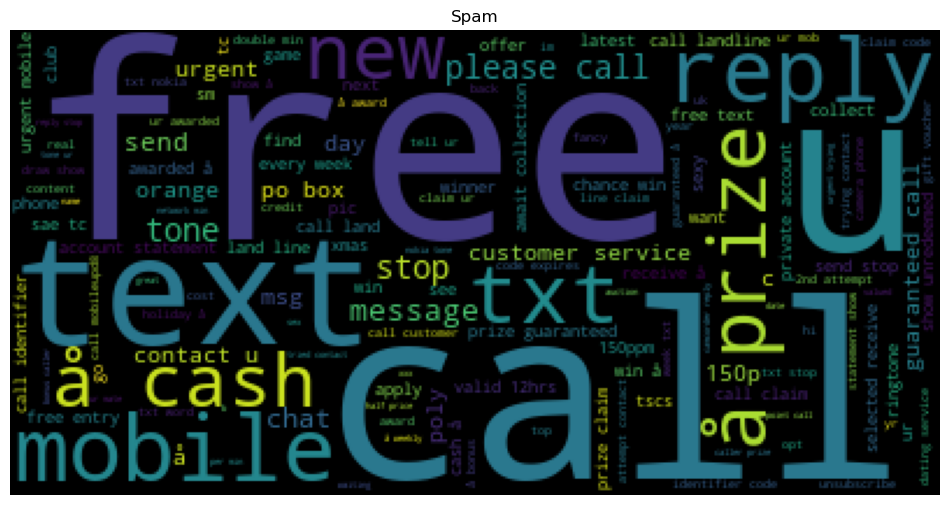

In [22]:
# Chmura słów dla spamów

wordcloud = WordCloud().generate(words_spam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Spam')
plt.show()

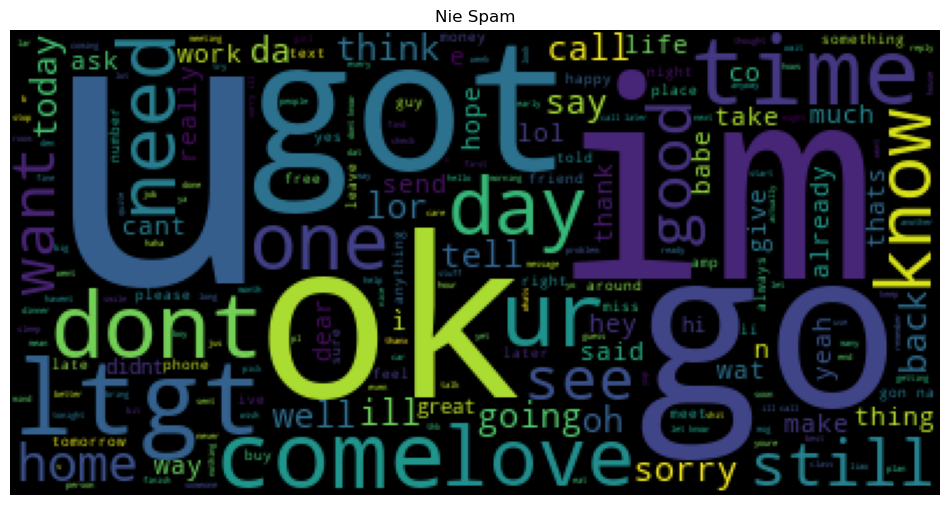

In [23]:
# Chmura słów dla nie-spamów

wordcloud = WordCloud().generate(words_notspam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nie Spam')
plt.show()

**#7 Podział na zbiór testowy i treningowy**

In [24]:
X = spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x))
y = spam_dataset['Spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**#8 Model bez LDA**

In [26]:
pipeline_no_lda = Pipeline([
    ('vectorizer', CountVectorizer(max_df=0.1, max_features=500)),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_no_lda.fit(X_train, y_train)
y_pred_no_lda = pipeline_no_lda.predict(X_test)
y_scores_no_lda = pipeline_no_lda.predict_proba(X_test)[:, 1]

**#9 Model z LDA**

In [27]:
pipeline_lda = Pipeline([
    ('vectorizer', CountVectorizer(max_df=0.1, max_features=500)),
    ('lda', LatentDirichletAllocation(n_components=7, random_state=42, learning_method='batch')),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_lda.fit(X_train, y_train)
y_pred_lda = pipeline_lda.predict(X_test)
y_scores_lda = pipeline_lda.predict_proba(X_test)[:, 1]

**#10 Ewaluacja modelu bez LDA**

In [ ]:
accuracy_no_lda = accuracy_score(y_test, y_pred_no_lda)
precision_no_lda = precision_score(y_test, y_pred_no_lda)
recall_no_lda = recall_score(y_test, y_pred_no_lda)
f1_no_lda = f1_score(y_test, y_pred_no_lda)
auc_no_lda = roc_auc_score(y_test, y_scores_no_lda)
classification_report

**#11 Ewaluacja modelu z LDA**

In [28]:
accuracy_lda = accuracy_score(y_test, y_pred_lda)
precision_lda = precision_score(y_test, y_pred_lda)
recall_lda = recall_score(y_test, y_pred_lda)
f1_lda = f1_score(y_test, y_pred_lda)
auc_lda = roc_auc_score(y_test, y_scores_lda)

**#12 Raport końcowy**

Porównanie metryk dla modelu bez LDA i z LDA:
Metryka        Bez LDA   Z LDA     
Accuracy       0.9704    0.9641    
Precision      0.9328    0.9504    
Recall         0.8389    0.7718    
F1-score       0.8834    0.8519    
AUC            0.9798    0.9501    

Raport klasyfikacji dla modelu bez LDA:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       966
           1       0.93      0.84      0.88       149

    accuracy                           0.97      1115
   macro avg       0.95      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115


Raport klasyfikacji dla modelu z LDA:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.95      0.77      0.85       149

    accuracy                           0.96      1115
   macro avg       0.96      0.88      0.92      1115
weighted avg       0.96      0.96      0.96      1115


Mac

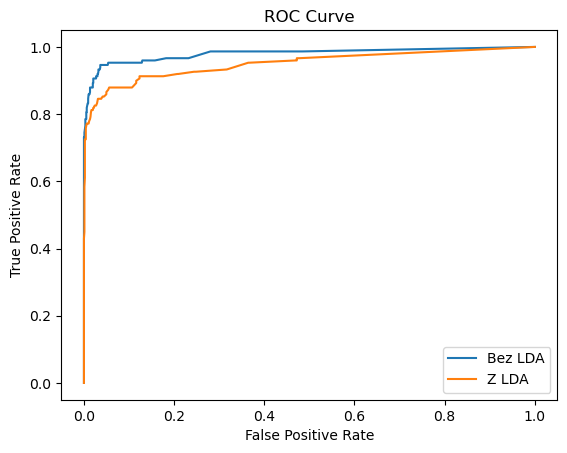

In [29]:
# Wyświetlenie wyników
print("Porównanie metryk dla modelu bez LDA i z LDA:")
print(f"{'Metryka':<15}{'Bez LDA':<10}{'Z LDA':<10}")
print(f"{'Accuracy':<15}{accuracy_no_lda:<10.4f}{accuracy_lda:<10.4f}")
print(f"{'Precision':<15}{precision_no_lda:<10.4f}{precision_lda:<10.4f}")
print(f"{'Recall':<15}{recall_no_lda:<10.4f}{recall_lda:<10.4f}")
print(f"{'F1-score':<15}{f1_no_lda:<10.4f}{f1_lda:<10.4f}")
print(f"{'AUC':<15}{auc_no_lda:<10.4f}{auc_lda:<10.4f}")

# Wyświetlenie raportu klasyfikacji
print("\nRaport klasyfikacji dla modelu bez LDA:")
print(classification_report(y_test, y_pred_no_lda))

print("\nRaport klasyfikacji dla modelu z LDA:")
print(classification_report(y_test, y_pred_lda))

# Wyświetlenie macierzy omyłek
print("\nMacierz omyłek dla modelu bez LDA:")
print(confusion_matrix(y_test, y_pred_no_lda))

print("\nMacierz omyłek dla modelu z LDA:")
print(confusion_matrix(y_test, y_pred_lda))

# Krzywa ROC
fpr_no_lda, tpr_no_lda, _ = roc_curve(y_test, y_scores_no_lda)
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_scores_lda)

plt.plot(fpr_no_lda, tpr_no_lda, label='Bez LDA')
plt.plot(fpr_lda, tpr_lda, label='Z LDA')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**#12 Podsumowanie**

Porównanie metryk:

Accuracy: Model bez LDA (0.9704) osiągnął wyższą dokładność niż model z LDA (0.9641).
Precision: Model z LDA (0.9504) ma wyższą precyzję niż model bez LDA (0.9328), co oznacza, że model z LDA rzadziej popełnia fałszywe pozytywne klasyfikacje.
Recall: Model bez LDA (0.8389) ma wyższy recall niż model z LDA (0.7718), co wskazuje, że model bez LDA lepiej wykrywa pozytywne przypadki.
F1-score: Model bez LDA (0.8834) ma lepszą równowagę między precyzją a recall niż model z LDA (0.8519).
AUC: Model bez LDA (0.9798) ma wyższy AUC, co sugeruje, że model bez LDA lepiej rozróżnia klasy.

Macierz omyłek:

Model bez LDA: 24 błędne klasyfikacje klasy 1 i 9 błędne klasyfikacje klasy 0.
Model z LDA: 34 błędne klasyfikacje klasy 1 i 6 błędne klasyfikacje klasy 0.

Podsumowanie: 

Model bez LDA wykazuje lepszą ogólną dokładność i wykrywanie pozytywnych przypadków, podczas gdy model z LDA lepiej radzi sobie z precyzyjniejszym przypisaniem klasy 1, ale ma nieco gorsze wyniki w zakresie recall i ogólnej wydajności.